# Denoising Autoencoder (AE)
In this notebook, we build a CNN-based autoencoder for denoising trained on the MNIST dataset. We used [Deep-Learning-Experiments](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/versions/2022/autoencoder/python/ae_pytorch_demo.ipynb) and [Building a CNN-based Autoencoder with Denoising in Python](https://medium.com/@polanitzer/building-a-cnn-based-autoencoder-with-denoising-in-python-on-gray-scale-images-of-hand-drawn-digits-61131ec492e4) as reference.

In [46]:
# Import necessary libraries
import os
import torch
from torch import nn
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import Accuracy
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from argparse import ArgumentParser
from PIL import Image
from matplotlib import pyplot as plt

We first create the Encoder module of our denoising autoencoder. The parameter num_filters dictates the number of filters in each convolution layer. The kernel sizes of $(3, 3)$ in the convolution layer and $(2,2)$ in the max pooling are consistent throughout all layers. ReLU is used as the activation function for all convolutions.

In [64]:
class AEEncoder(nn.Module):
    def __init__(self, img_channels=1, num_filters=64):
        super().__init__()
        
        # Build the CNN layers
        self.conv0 = nn.Conv2d(in_channels=img_channels, out_channels=num_filters, kernel_size=3, padding='same')
        self.conv1 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, padding='same')
        # Build the ReLU activation function
        self.relu = nn.ReLU()
        # Build the Max Pool layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        # First Convolutional Layer
        y = self.conv0(x)
        y = self.relu(y)
        y = self.maxpool(y)

        # Second Convolutional Layer
        y = self.conv1(y)
        y = self.relu(y)
        y = self.maxpool(y)
        
        return y

Now, we create the Decoder module of our denoising autoencoder. Like the encoder, the parameter num_filters dictates the number of filters in each convolution layer and the same kernel size for convolution is consistent throughout all layers. We have substituted the max pool layer into an upsampling layer for our decoder. ReLU is used as the activation function for the first two convolutions, while the sigmoid function is used for the final convolution layer.

In [65]:
class AEDecoder(nn.Module):
    def __init__(self, img_channels=1, num_filters=64):
        super().__init__()
        
        # Build the CNN layers
        self.conv0 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, padding='same')
        self.conv1 = nn.Conv2d(in_channels=num_filters, out_channels=img_channels, kernel_size=3, padding='same')
        # Build the activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        # Build the Upsampling layer
        self.upsample0 = nn.Upsample(size=(14,14))
        self.upsample1 = nn.Upsample(size=(28,28))

    def forward(self, x):
        # First Convolutional Layer
        y = self.conv0(x)
        y = self.relu(y)
        y = self.upsample0(y)

        # Second Convolutional Layer
        y = self.conv0(y)
        y = self.relu(y)
        y = self.upsample1(y)

        # Second Convolutional Layer
        y = self.conv1(y)
        y = self.sigmoid(y)
        
        return y

*Note: In getting the correct sizes for the Upsampling layer, we can determine this by extracting the output shape of each layer for a random tensor.*

In [50]:
conv0 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
conv1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
relu = nn.ReLU()
maxpool0 = nn.MaxPool2d(kernel_size=2)
maxpool1 = nn.MaxPool2d(kernel_size=2)

x = torch.randn(5, 1, 28, 28)
print(f'Shape 0: {x.shape}')
y = relu(conv0(x))
print(f'Shape 1: {y.shape}')
y = maxpool0(y)
print(f'Shape 2: {y.shape}')
y = relu(conv1(y))
print(f'Shape 3: {y.shape}')
y = maxpool1(y)
print(f'Shape 4: {y.shape}')


conv0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
conv1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding='same')
sigmoid = nn.Sigmoid()
upsample0 = nn.Upsample(size=(14,14))
upsample1 = nn.Upsample(size=(28,28))
y = relu(conv0(y))
print(f'Shape 6: {y.shape}')
y = upsample0(y)
print(f'Shape 7: {y.shape}')
y = relu(conv0(y))
print(f'Shape 8: {y.shape}')
y = upsample1(y)
print(f'Shape 9: {y.shape}')
y = sigmoid(conv1(y))
print(f'Shape 10: {y.shape}')

Shape 0: torch.Size([5, 1, 28, 28])
Shape 1: torch.Size([5, 32, 28, 28])
Shape 2: torch.Size([5, 32, 14, 14])
Shape 3: torch.Size([5, 32, 14, 14])
Shape 4: torch.Size([5, 32, 7, 7])
Shape 6: torch.Size([5, 32, 7, 7])
Shape 7: torch.Size([5, 32, 14, 14])
Shape 8: torch.Size([5, 32, 14, 14])
Shape 9: torch.Size([5, 32, 28, 28])
Shape 10: torch.Size([5, 1, 28, 28])


We now define the noise that we will introduce to our train and test data through the collate_fn function. For this experiment, we applied a Gaussian noise with a mean of $0.0$ and a standard deviation of $1.0$ multiplied by the noise_factor, which is $0.5$ in this specific setup.

In [66]:
def noise_collate_fn(batch):
    x, _ = zip(*batch)
    x = torch.stack(x, dim=0)
    noise = 0.5 * torch.normal(mean=0., std=1., size=x.shape)
    xn = x + noise
    xn = torch.clip(xn, 0, 1)
    return xn, x

We now perform the necessary preparations for the dataset and training, using the PyTorch Lightning module.

In [67]:
class MNISTDenoiseAEModel(pl.LightningModule):
    def __init__(self, lr=0.001, batch_size=64, num_workers=4, max_epochs=30, num_filters=32, encoder=AEEncoder, decoder=AEDecoder, optim="adam"):
        # Initiate LightningModule superclass
        super().__init__()
        self.train_step_outputs = []
        self.test_step_outputs = []

        # Set up other parameters
        self.save_hyperparameters()
        self.encoder = encoder(num_filters=num_filters)
        self.decoder = decoder(num_filters=num_filters)
        # Set up loss function (Mean Squared Error) and accuracy
        self.loss = nn.BCELoss()
        self.optim = optim 

    def forward(self,x):
        h = self.encoder(x)
        return self.decoder(h)

    def training_step(self, batch, batch_idx):
        xn, x = batch
        y = self.forward(xn)
        loss = self.loss(y, x)
        self.train_step_outputs.append({"loss": loss})
        return loss
    
    def on_train_epoch_end(self):
        avg_loss = torch.stack([x["loss"] for x in self.train_step_outputs]).mean()
        print(f'Train loss: {avg_loss}')
        self.train_step_outputs.clear()
        self.log("train_loss", avg_loss, on_epoch=True)
    
    def test_step(self, batch, batch_idx):
        xn, x = batch
        y = self.forward(xn)
        loss = self.loss(y, x)
        self.test_step_outputs.append({"xn": xn, "y": y, "test_loss": loss})
        return xn, y, loss
    
    def on_test_epoch_end(self):
        avg_loss = torch.stack([x["test_loss"] for x in self.test_step_outputs]).mean()
        print(f'Test loss: {avg_loss}')
        self.test_step_outputs.clear()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)

    def validation_step(self, batch, batch_idx):
       return self.test_step(batch, batch_idx)

    def on_validation_epoch_end(self):
        return self.on_test_epoch_end()
    
    def configure_optimizers(self):
        if self.optim == "adam":
            optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        elif self.optim == "sgd":
            optimizer = SGD(self.parameters(), lr=self.hparams.lr)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler]

    # Settings from https://nextjournal.com/gkoehler/pytorch-mnist
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.MNIST('/files/', train=True, download=True,
                                        transform=torchvision.transforms.ToTensor()), 
                                        batch_size=self.hparams.batch_size, shuffle=True, pin_memory=True, collate_fn=noise_collate_fn)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.MNIST('/files/', train=False, download=True,
                                        transform=torchvision.transforms.ToTensor()), 
                                        batch_size=self.hparams.batch_size, shuffle=False, pin_memory=True, collate_fn=noise_collate_fn)
    
    def val_dataloader(self):
        return self.test_dataloader()
    
    def setup(self, stage=None):
        self.train_dataloader()
        self.test_dataloader()

After setting up the model, the datasets, and the train/test/validation configurations, we set up the arguments.

In [68]:
def get_args():
    parser = ArgumentParser(description="PyTorch Lightning MNIST Example")
    parser.add_argument("--epochs", type=int, default=30, help="num epochs")
    parser.add_argument("--batch-size", type=int, default=64, help="batch size")
    parser.add_argument("--lr", type=float, default=0.001, help="learning rate")
    parser.add_argument("--num_filters", default=32, help="num filters")

    parser.add_argument("--optim", default="adam", help="optimizer")
    # Verify device count with torch.cuda.device_count()
    parser.add_argument("--devices", default=1)
    # Verify CUDA availability with torch.cuda.is_available())
    parser.add_argument("--accelerator", default='gpu')
    # Recommended: num_workers = (os.cpu_count() // 2) // torch.cuda.device_count()
    parser.add_argument("--num-workers", type=int, default=4, help="num workers")

    parser.add_argument("--encoder", default=AEEncoder)
    parser.add_argument("--decoder", default=AEDecoder)
    parser.add_argument("--path", default="models", help="Model save path")
    args = parser.parse_args("")
    return args

Now, we train the Autoencoder model with the MNIST dataset.

In [69]:
if __name__ == "__main__":
    args = get_args()
    model = MNISTDenoiseAEModel(lr=args.lr, batch_size=args.batch_size,
                           num_workers=args.num_workers, num_filters=args.num_filters,
                           encoder=args.encoder, decoder=args.decoder, optim=args.optim)
    model.setup()
    print(model)

    model_checkpoint = ModelCheckpoint(
        dirpath=os.path.join(args.path, "checkpoints"),
        filename="mnist-ae-best-acc",
        save_top_k=1,
        verbose=True,
        monitor='test_loss',
        mode='min')

    trainer = pl.Trainer(accelerator=args.accelerator,
                      devices=args.devices,
                      max_epochs=args.epochs,
                      callbacks=model_checkpoint)

    trainer.fit(model)
    trainer.test(model)

    model = model.load_from_checkpoint(os.path.join(args.path, "checkpoints", "mnist-ae-best-acc.ckpt"))
    model.eval()
    script = model.to_torchscript()
    model_path = os.path.join(args.path, "checkpoints", "mnist-ae-best-acc.pt")
    torch.jit.save(script, model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | encoder | AEEncoder | 9.6 K 
1 | decoder | AEDecoder | 9.5 K 
2 | loss    | BCELoss   | 0     
--------------------------------------
19.1 K    Trainable params
0         Non-trainable params
19.1 K    Total params
0.076     Total estimated model params size (MB)


MNISTDenoiseAEModel(
  (encoder): AEEncoder(
    (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): AEDecoder(
    (conv0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv1): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (upsample0): Upsample(size=(14, 14), mode='nearest')
    (upsample1): Upsample(size=(28, 28), mode='nearest')
  )
  (loss): BCELoss()
)
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 167.11it/s]Test loss: 0.6836158037185669
                                                                            

c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 938/938 [00:11<00:00, 79.43it/s, v_num=5, test_loss=0.112]

Epoch 0, global step 938: 'test_loss' reached 0.11186 (best 0.11186), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Train loss: 0.14627404510974884
Epoch 1: 100%|██████████| 938/938 [00:12<00:00, 76.34it/s, v_num=5, test_loss=0.105]Train loss: 0.10924789309501648


Epoch 1, global step 1876: 'test_loss' reached 0.10489 (best 0.10489), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 2: 100%|██████████| 938/938 [00:12<00:00, 72.68it/s, v_num=5, test_loss=0.102]

Epoch 2, global step 2814: 'test_loss' reached 0.10214 (best 0.10214), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Train loss: 0.10466042906045914
Epoch 3: 100%|██████████| 938/938 [00:12<00:00, 72.44it/s, v_num=5, test_loss=0.100]

Epoch 3, global step 3752: 'test_loss' reached 0.10039 (best 0.10039), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Train loss: 0.1023128479719162
Epoch 4: 100%|██████████| 938/938 [00:12<00:00, 72.58it/s, v_num=5, test_loss=0.100]Train loss: 0.10090284794569016


Epoch 4, global step 4690: 'test_loss' reached 0.10000 (best 0.10000), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 5: 100%|██████████| 938/938 [00:13<00:00, 71.72it/s, v_num=5, test_loss=0.0983]Train loss: 0.09993486851453781


Epoch 5, global step 5628: 'test_loss' reached 0.09829 (best 0.09829), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 6: 100%|██████████| 938/938 [00:13<00:00, 71.71it/s, v_num=5, test_loss=0.0977]Train loss: 0.09921788424253464


Epoch 6, global step 6566: 'test_loss' reached 0.09772 (best 0.09772), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 7: 100%|██████████| 938/938 [00:13<00:00, 70.89it/s, v_num=5, test_loss=0.0978]Train loss: 0.09861350804567337


Epoch 7, global step 7504: 'test_loss' was not in top 1


Epoch 8: 100%|██████████| 938/938 [00:13<00:00, 71.42it/s, v_num=5, test_loss=0.0971]Train loss: 0.09840995818376541


Epoch 8, global step 8442: 'test_loss' reached 0.09709 (best 0.09709), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 9: 100%|██████████| 938/938 [00:12<00:00, 72.19it/s, v_num=5, test_loss=0.097] Train loss: 0.09794747084379196


Epoch 9, global step 9380: 'test_loss' reached 0.09697 (best 0.09697), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 10: 100%|██████████| 938/938 [00:12<00:00, 72.17it/s, v_num=5, test_loss=0.097]Train loss: 0.09764152020215988


Epoch 10, global step 10318: 'test_loss' was not in top 1


Epoch 11: 100%|██████████| 938/938 [00:13<00:00, 71.97it/s, v_num=5, test_loss=0.0963]

Epoch 11, global step 11256: 'test_loss' reached 0.09632 (best 0.09632), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Train loss: 0.09740780293941498
Epoch 12: 100%|██████████| 938/938 [00:13<00:00, 71.78it/s, v_num=5, test_loss=0.0962]Train loss: 0.09721986204385757


Epoch 12, global step 12194: 'test_loss' reached 0.09619 (best 0.09619), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 13: 100%|██████████| 938/938 [00:12<00:00, 73.13it/s, v_num=5, test_loss=0.0963]Train loss: 0.09699399024248123


Epoch 13, global step 13132: 'test_loss' was not in top 1


Epoch 14: 100%|██████████| 938/938 [00:12<00:00, 73.55it/s, v_num=5, test_loss=0.0959]Train loss: 0.0968688502907753


Epoch 14, global step 14070: 'test_loss' reached 0.09587 (best 0.09587), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 15: 100%|██████████| 938/938 [00:12<00:00, 73.30it/s, v_num=5, test_loss=0.0957]Train loss: 0.09674866497516632


Epoch 15, global step 15008: 'test_loss' reached 0.09568 (best 0.09568), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 16: 100%|██████████| 938/938 [00:12<00:00, 73.89it/s, v_num=5, test_loss=0.0957]

Epoch 16, global step 15946: 'test_loss' was not in top 1


Train loss: 0.09661473333835602
Epoch 17: 100%|██████████| 938/938 [00:12<00:00, 72.63it/s, v_num=5, test_loss=0.0956]Train loss: 0.09647990763187408


Epoch 17, global step 16884: 'test_loss' reached 0.09561 (best 0.09561), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 18: 100%|██████████| 938/938 [00:12<00:00, 73.83it/s, v_num=5, test_loss=0.0956]

Epoch 18, global step 17822: 'test_loss' was not in top 1


Train loss: 0.09641473740339279
Epoch 19: 100%|██████████| 938/938 [00:12<00:00, 73.82it/s, v_num=5, test_loss=0.0956]Train loss: 0.0963536873459816


Epoch 19, global step 18760: 'test_loss' reached 0.09559 (best 0.09559), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 20: 100%|██████████| 938/938 [00:12<00:00, 73.76it/s, v_num=5, test_loss=0.0955]Train loss: 0.09627275913953781


Epoch 20, global step 19698: 'test_loss' reached 0.09550 (best 0.09550), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 21: 100%|██████████| 938/938 [00:12<00:00, 73.87it/s, v_num=5, test_loss=0.0953]Train loss: 0.09615650027990341


Epoch 21, global step 20636: 'test_loss' reached 0.09529 (best 0.09529), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 22: 100%|██████████| 938/938 [00:12<00:00, 73.44it/s, v_num=5, test_loss=0.0952]Train loss: 0.0961398258805275


Epoch 22, global step 21574: 'test_loss' reached 0.09515 (best 0.09515), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 23: 100%|██████████| 938/938 [00:12<00:00, 72.35it/s, v_num=5, test_loss=0.0952]Train loss: 0.0960787981748581


Epoch 23, global step 22512: 'test_loss' was not in top 1


Epoch 24: 100%|██████████| 938/938 [00:13<00:00, 71.87it/s, v_num=5, test_loss=0.0949]Train loss: 0.09597466140985489


Epoch 24, global step 23450: 'test_loss' reached 0.09493 (best 0.09493), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1


Epoch 25: 100%|██████████| 938/938 [00:13<00:00, 71.76it/s, v_num=5, test_loss=0.0951]Train loss: 0.09599713236093521


Epoch 25, global step 24388: 'test_loss' was not in top 1


Epoch 26: 100%|██████████| 938/938 [00:13<00:00, 69.69it/s, v_num=5, test_loss=0.095] Train loss: 0.09599431604146957


Epoch 26, global step 25326: 'test_loss' was not in top 1


Epoch 27: 100%|██████████| 938/938 [00:14<00:00, 62.58it/s, v_num=5, test_loss=0.0952]Train loss: 0.09594899415969849


Epoch 27, global step 26264: 'test_loss' was not in top 1


Epoch 28: 100%|██████████| 938/938 [00:14<00:00, 65.90it/s, v_num=5, test_loss=0.0951]Train loss: 0.09592968225479126


Epoch 28, global step 27202: 'test_loss' was not in top 1


Epoch 29: 100%|██████████| 938/938 [00:14<00:00, 65.22it/s, v_num=5, test_loss=0.0949]Train loss: 0.09593285620212555


Epoch 29, global step 28140: 'test_loss' reached 0.09493 (best 0.09493), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\AE\\models\\checkpoints\\mnist-ae-best-acc.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 938/938 [00:14<00:00, 65.11it/s, v_num=5, test_loss=0.0949]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 116.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.09500822424888611
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### Notes
* We have observed that test loss gradually decreases to each epoch, which ultimately goes down to a final net loss of around $0.095$.

#### Inference of the trained model on handwritten digits
Now that we have successfully trained and saved the model, we use it for denoising noisy digit images. We used a noisy version of a handwritten digit $7$ and feed it into our autoencoder model. Upon observation, we have seen that the model properly denoises the image, leaving out only the important features that define the digit $7$.

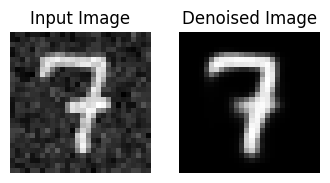

In [89]:
scripted_module = torch.jit.load('models/checkpoints/mnist-ae-best-acc.pt')
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((28,28)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Grayscale(num_output_channels=1)])

# create figure
fig = plt.figure(figsize=(4, 2))
  
# setting values to rows and column variables
rows = 1
columns = 2

img = Image.open('noisy_digit.png')
img = img.convert('RGB')
img = transform(img)
img = torch.unsqueeze(img,0)
img = img.to('cuda')
denoised_img = scripted_module(img)
denoised_img = torchvision.transforms.ToPILImage()(torch.squeeze(denoised_img))
img = torchvision.transforms.ToPILImage()(torch.squeeze(img))

fig.add_subplot(rows, columns, 1)
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.title("Input Image")

fig.add_subplot(rows, columns, 2)
plt.imshow(denoised_img, cmap="gray")
plt.axis('off')
plt.title("Denoised Image")

plt.show()